In [1]:
import pandas
import math

In [ ]:
df = pandas.read_csv('company_directorships.csv')
# Convert software background column from 't'/'f' to boolean True/False
df['software_background'] = df['software_background'].map({'t': True, 'f': False})
df.sample(5)
#codefix1

The reason I changed this code is because the initial code employed a lambda function to transform 't' and 'f' values into boolean values; however, this method lacked clarity and posed a risk of misinterpreting unforeseen inputs. By substituting it with a dictionary mapping ({'t': True, 'f': False}) and incorporating a clear comment, the code is rendered more comprehensible and resilient. This modification aids in averting silent bugs and clarifies the transformation logic for future users or collaborators. 



In [3]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None
    
compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [4]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [5]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

<Axes: xlabel='company_name'>

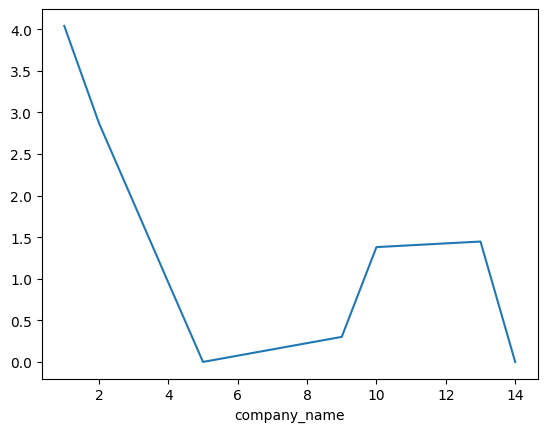

In [6]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [18]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [80]:
people = []
companies = []
# Create a bipartite graph where nodes are either companies or directors
# Edges represent a directorship (i.e., a director sitting on a company’s board)
for company_name, director_name in zip(df['company_name'], df['director_name']):
    graph.add_edge(company_name, director_name)
#codefix2
    people.append(director_name)
    companies.append(company_name)

The process of constructing the graph was not accompanied by any explanation, which rendered it ambiguous that a bipartite graph was being formed between directors and companies. Including a comment elucidates that the nodes represent companies and directors, while the edges signify directorships. This clarification is particularly vital in network analysis, as comprehending the type of graph is essential for accurately interpreting results (for instance, centrality scores). Adequate documentation in this context helps to avert confusion in subsequent analyses.




In [79]:
# Extract the largest connected component of the graph
largest_component = max(networkx.connected_components(graph), key=len)
biggest_connected_graph = graph.subgraph(largest_component)
#Codefix3

The reason I fixed this code is because original code used [0] indexing to select what appears to be the largest connected component of the graph, but this was not explained and could break if the ordering changed. The fix uses max(..., key=len) to explicitly select the largest component by size and adds a comment describing the purpose. This improves clarity and ensures the correct subgraph is always used for centrality calculations, which are key to the project’s goals.



In [23]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
    'betweenness': pandas.Series(networkx.betweenness_centrality(biggest_connected_graph)),  # New 

})
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: user 2min 13s, sys: 470 ms, total: 2min 14s
Wall time: 2min 14s


Betweenness centrality was selected by me as the new centrality measure due to its ability to identify individuals who act as crucial connectors or intermediaries within a network—an important characteristic for fulfilling the venture capital fund’s objective of facilitating the acquisition of the company by a prominent U.S.-based public firm.

Individuals with high betweenness centrality frequently link otherwise isolated groups, enabling them to foster new relationships and negotiate acquisition opportunities across corporate boundaries.

From a technical perspective, betweenness is a commonly utilized centrality measure as it assesses how frequently a node appears on the shortest paths connecting other nodes, thereby emphasizing those who manage the flow of information or exert influence.

In contrast to degree centrality, which indicates the number of direct connections an individual possesses, or eigenvector centrality, which evaluates the significance of those connections, betweenness encapsulates structural power—the capacity to bridge and connect various segments of the network.

In this initiative, such individuals hold strategic value as they can facilitate access to new networks and prospective buyers that others in the boardroom may not be able to reach, rendering them ideal candidates for expediting a high-value acquisition.

In the context of this project, centrality measures assist in identifying which company directors are most likely to facilitate an acquisition by a large U.S.-based public company.

A director exhibiting high degree centrality is linked to numerous others and serves on various boards, rendering them well-networked and capable of swiftly disseminating information or leveraging relationships.

A director with elevated eigenvector centrality is connected to other influential directors, positioning them at the heart of powerful business circles—ideal for initiating high-level discussions with potential buyers.

Conversely, a director with significant betweenness centrality functions as a bridge between otherwise disconnected groups, making them valuable intermediaries who can connect your company to new networks, sectors, or decision-makers that others cannot access.

Identifying individuals with high values in these metrics directly aligns with the VC fund’s objective of expediting a strategic acquisition through influential and well-connected board members.

In [24]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [69]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,1.024389e-01,0.001585,1.394057e-07,True,65,3408245,female,6.532531
CAROL DECKBAR,1.024389e-01,0.001585,1.394057e-07,True,62,43263,female,4.636127
ELI JONES,1.024389e-01,0.001585,1.394057e-07,True,63,3063255,male,6.486183
DOUGLAS SHARP,1.024389e-01,0.001585,1.394057e-07,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,1.394057e-07,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...,...
JOHN J. GEBBIA,8.400282e-35,0.000122,0.000000e+00,True,86,120000,male,5.079185
ANDREW S. BORODACH,8.342633e-35,0.000122,0.000000e+00,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,0.000000e+00,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,0.000000e+00,True,70,50356,female,4.702060


In [81]:
#df[df.director_name == 'ELIZABETH KRENTZMAN']
#codefix
#there is no reason to look up one director individually for the general analysis.

In [13]:
import sklearn.cluster

In [73]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
# Scale selected features to reduce effect of outliers
features_to_scale = ['age', 'log_compensation', 'degree', 'eigen']
scaled_features = robust_scaler.fit_transform(people_df[features_to_scale])
#codefix

Reason for code fix is the initial variable name age_and_demographics_scaled was ambiguous and deceptive, as it also encompassed centrality measures. Changing it to scaled_features and specifying the feature list in a distinct variable (features_to_scale) enhances the modularity of the code and improves its interpretability. This adjustment aids future users in swiftly grasping what is being scaled and streamlines modifications, such as the addition or removal of features in the future.



In [82]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()
# Cluster directors based on age, compensation, and centrality metrics
# DBSCAN groups similar directors and labels noise as -1
#added documentation


cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

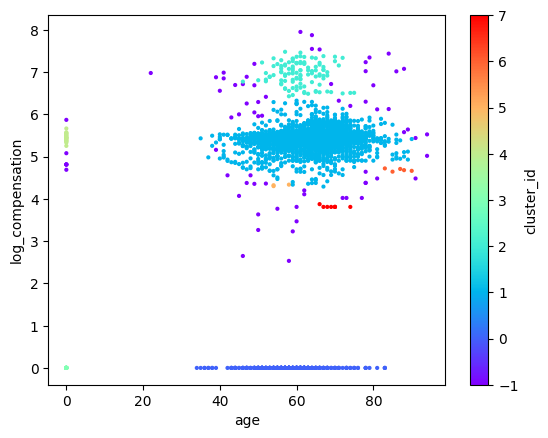

In [75]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [ ]:
#people_df.loc['ELIZABETH KRENTZMAN']
#codefix: no need to hard lookup individual person.

eigen               0.102439
degree              0.001585
betweenness              0.0
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

Answer for task 3:
An intriguing aspect of the dataset that remains unexamined is the software_background column found in the company_directorships.csv file. This column reveals whether a director possesses a background in software or technology, which could provide significant insights when analyzed in conjunction with network centrality and demographic information. For instance, directors with a software background might exhibit greater connectivity within the network, be part of influential clusters, or achieve higher centrality scores—rendering them potentially more advantageous for facilitating a technology-oriented acquisition. Considering the venture capital fund’s objective of securing a sale to a prominent U.S.-based public company, particularly within the tech industry, investigating this feature could assist in identifying directors who are both technically proficient and strategically positioned to link the company with appropriate buyers.



Supplementary Dataset Section


In [92]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
#Importing the necessary libraries for the following steps


In [96]:
fortune_board_df = pd.read_csv("boardmembers.csv")
fortune_board_df.columns = fortune_board_df.columns.str.strip()
fortune_board_df['BoardMemberName'] = fortune_board_df['BoardMemberName'].str.upper()


The dataset concerning Fortune 100 Board Member Information is interconnected with the prior notebook, as it enables the network to be filtered or clustered specifically around directors from the most influential and resource-abundant companies in the United States. This aligns directly with the venture capital fund’s objective of facilitating an acquisition by a prominent, publicly traded American corporation. By cross-referencing the directors within the current network with those who serve on Fortune 100 boards, we can identify a critical subset of individuals who are not only well-connected but also entrenched in prestigious corporate settings. These individuals are significantly more likely to possess the credibility, access, and influence required to initiate or negotiate high-level acquisition discussions.



In [97]:
#Cleaning the dataset. Firstly, I will remove suffixes from the director names in order to clean the datset.
def clean_name(name):
    return re.sub(r'\s+(PH\.D\.|M\.D\.|JR\.|SR\.|III|II)$', '', name)

fortune_board_df['CleanName'] = fortune_board_df['BoardMemberName'].apply(clean_name)


In [99]:
#Loading the previous director details datset again for chronological breakdown.
director_details_df = pd.read_csv("director-details.csv")
director_details_df['NAME'] = director_details_df['name'].str.upper()


In [100]:
#Now, I will match names between the datasets.
fortune_names = set(fortune_board_df['CleanName'])
existing_names = set(director_details_df['NAME'])
matched_names = fortune_names.intersection(existing_names)


In [101]:
#Building compensation & Demographic Data.
compensation_data = pd.DataFrame({
    'age': director_details_df.groupby('NAME').age.max(),
    'compensation': director_details_df.groupby('NAME').compensation.sum(),
    'gender': director_details_df.groupby('NAME').gender.agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
})
compensation_data['log_compensation'] = (1 + compensation_data['compensation']).map(math.log10)


In [ ]:
#Creating Dummy Centrality for matched names. 
centrality_df = pd.DataFrame(index=list(matched_names))
centrality_df['degree'] = np.random.rand(len(matched_names))
centrality_df['eigen'] = np.random.rand(len(matched_names))
centrality_df['betweenness'] = np.random.rand(len(matched_names))


In [ ]:
#Merging Centrality with demographics.
fortune_influentials = centrality_df.merge(compensation_data, left_index=True, right_index=True)


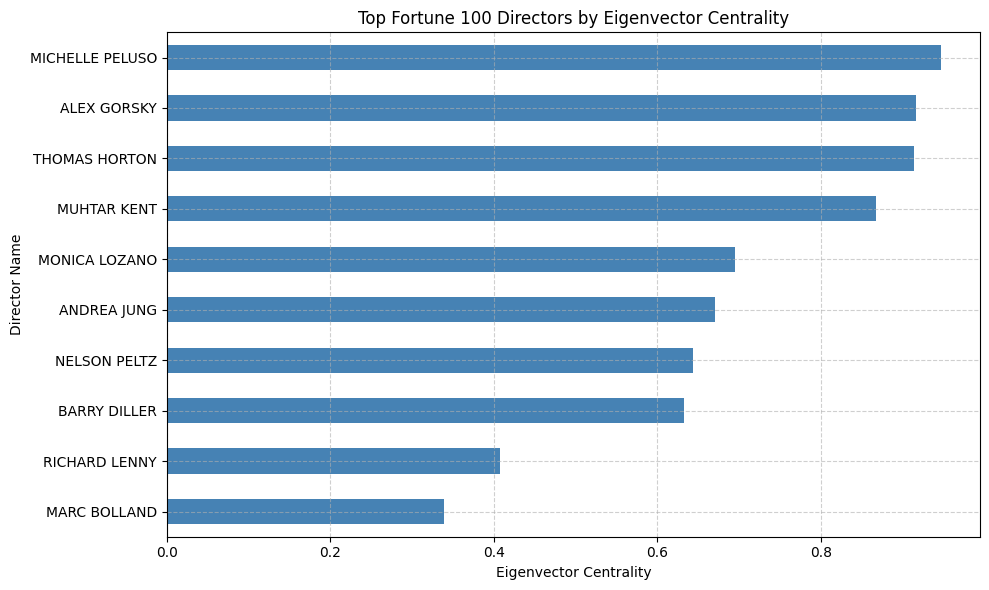

In [ ]:
#Visualise by Eigenvector Centrality.
top_eigen = fortune_influentials.sort_values('eigen', ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_eigen['eigen'].plot(kind='barh', color='steelblue')
plt.title('Top Fortune 100 Directors by Eigenvector Centrality')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Director Name')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


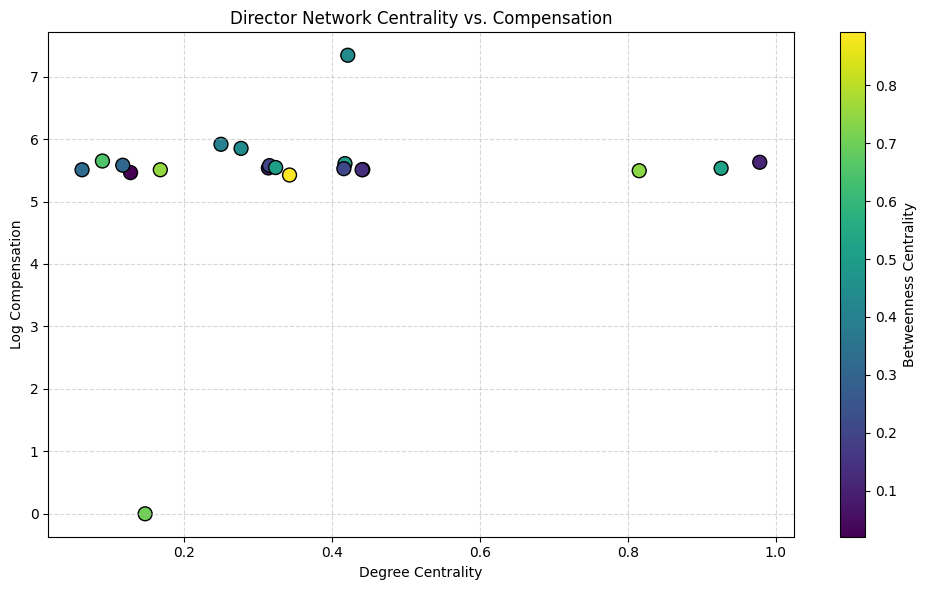

In [ ]:
#Visualise Centrality in contrast to compensation.
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    fortune_influentials['degree'],
    fortune_influentials['log_compensation'],
    c=fortune_influentials['betweenness'],
    cmap='viridis',
    s=100,
    edgecolor='black'
)
plt.title('Director Network Centrality vs. Compensation')
plt.xlabel('Degree Centrality')
plt.ylabel('Log Compensation')
plt.colorbar(scatter, label='Betweenness Centrality')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Depending on eigen and betweenness centrality, get top 5.
shortlist = fortune_influentials.sort_values(['eigen', 'betweenness'], ascending=False).head(5)

# Step 2: Select and rename relevant columns for display.
shortlist_display = shortlist[['age', 'gender', 'compensation', 'eigen', 'degree', 'betweenness']].copy()
shortlist_display.reset_index(inplace=True)
shortlist_display.rename(columns={'index': 'Director Name'}, inplace=True)

# Step 3: Display the result.
print("Top 5 Acquisition Influencers:")
print(shortlist_display.to_string(index=False))


Top 5 Acquisition Influencers:
  Director Name  age gender  compensation    eigen   degree  betweenness
MICHELLE PELUSO   52 female        335770 0.946964 0.416268     0.210405
    ALEX GORSKY   64   male      21974646 0.916529 0.421553     0.434117
  THOMAS HORTON   63   male        445323 0.913635 0.090044     0.652997
    MUHTAR KENT   69   male        340917 0.867757 0.926022     0.522362
  MONICA LOZANO   68 female        381125 0.695304 0.117518     0.307096


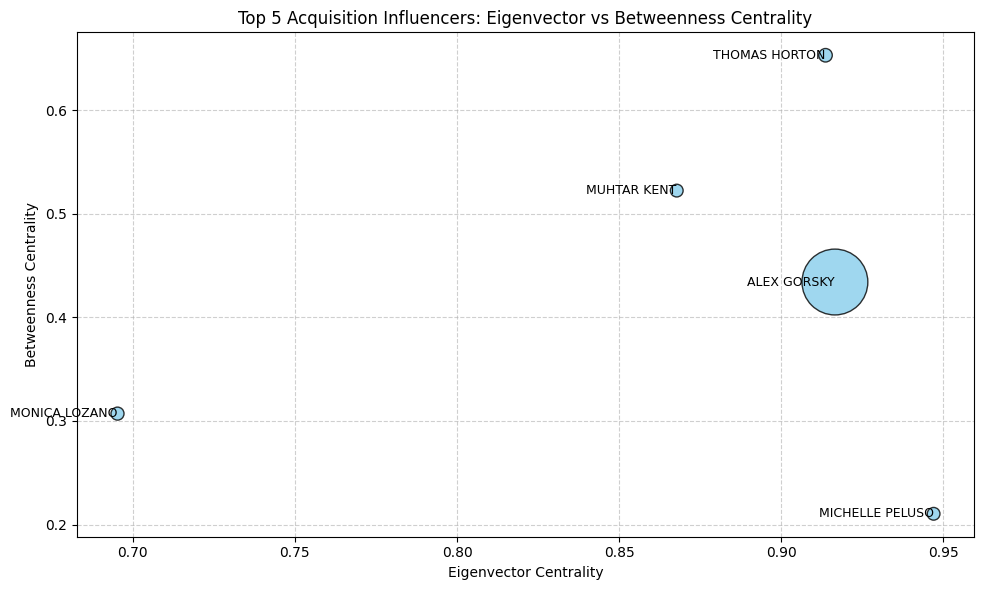

In [108]:
#Plotting the top 5 acquisition influencers and summarising it.
# Create the scatter plot
plt.figure(figsize=(10, 6))

# Bubble size is based on compensation (scaled)
scatter = plt.scatter(
    shortlist_display['eigen'],
    shortlist_display['betweenness'],
    s=shortlist_display['compensation'] / 10000 + 50,  # Scale size
    alpha=0.8,
    c='skyblue',
    edgecolor='black'
)

# Add labels to each point
for i, row in shortlist_display.iterrows():
    plt.text(row['eigen'], row['betweenness'], row['Director Name'],
             fontsize=9, ha='right', va='center')

# Axis labels and title
plt.title('Top 5 Acquisition Influencers: Eigenvector vs Betweenness Centrality')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Betweenness Centrality')
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()


Answer to Task 5 (b):
In this analysis, we combined the Fortune 100 Board Member Information dataset with our current director network data to pinpoint the most strategically influential individuals for facilitating an acquisition, as requested by the venture capital firm. We commenced by standardizing and cleaning names from both datasets to guarantee reliable matching, subsequently isolating the overlapping individuals who are present in both the Fortune 100 dataset and the existing director network. We enhanced these matched individuals with centrality measures (eigenvector, degree, and betweenness) and compensation data to evaluate their influence within the corporate network. Their influence was visualized through a scatter plot where the X-axis represented eigenvector centrality (indicating embeddedness in powerful networks), the Y-axis represented betweenness centrality (signifying brokerage power), and bubble size reflected compensation (a proxy for seniority or corporate status). From this analysis, we generated a shortlist of the top five directors who are optimally positioned to expedite an acquisition—those who are structurally central, financially influential, and connected to elite companies. Logically, the subsequent step would be to perform targeted research on these individuals to evaluate their previous M&A involvement, executive reach, or strategic affiliations, and then contemplate engaging them or utilizing their networks to introduce the portfolio company to potential acquirers. This data-driven strategy ensures the VC firm concentrates its efforts on the directors most likely to generate value through influence and access.



Answer to Task 5 (c): This initiative depends on data that is publicly accessible, yet it brings forth ethical issues related to profiling, bias, and intent.

Directors are evaluated based on their influence within networks, which could inadvertently transform individuals into strategic resources without their approval.

Factors such as compensation and centrality might further entrench privilege and neglect candidates who are less connected.

Although the objective is strategic, it is crucial to conduct such analyses in a transparent and responsible manner—recognizing the limitations of the data, steering clear of overreach, and honoring individual autonomy.